In [1]:
import numpy as np
import math
from copy import deepcopy
import sklearn.datasets
from sklearn.svm import SVC
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score

In [2]:
X,y = sklearn.datasets.make_hastie_10_2()
X_train = X[0:8000,:]
y_train = y[0:8000]
X_test = X[8000:,:]
y_test = y[8000:]
print(X[0]) # 10 feature
print(y[0]) # target label

[ 0.67873999  0.80032636 -1.27873534  1.99093232 -0.52142512  0.13991086
  1.35578208  0.10682781  0.71529817 -0.09758231]
1.0


# Exercise 1

1. Implement the AdaBoost ensemble algorithm by completing the following code:

In [3]:
#SVC with weight correction, as suggested
class SVC_:
        def __init__(self, kernel="rbf", degree="3"):
            self.svc = SVC(kernel=kernel, degree=degree)

        def fit(self, X,y,sample_weight=None):
            if sample_weight is not None:
                sample_weight = sample_weight * len(X)

            self.svc.fit(X,y,sample_weight=sample_weight)
            return self

        def predict(self, X):
            return self.svc.predict(X)

In [4]:
#utility error function
def compute_error(y_true, y_pred):
    return 0.5 - np.dot(y_true.T, y_pred) / (y_true.size * 2)

In [5]:
class AdaBoost: 
    def __init__(self, _weakModel, _T, k_step=10):
        self.T = _T
        self.weakModel = _weakModel
        self.alphas = []
        self.models = []
        self.errors = [] # ensamble error
        self.weight_error = []
        self.k_step = k_step


    def fit(self, X, y):
        # Distribuzione uniforme dei pesi associati agli esempi [1/|D|]
        w_start = 1 / len(X_train) # peso di un singolo esempio
        self.w = np.zeros(len(X_train)) 
        self.w.fill(w_start) # inseriemo i valori iniziali w_start
        
        partial_ensamble_pred = np.zeros(y.size)
        
        for t in range(0, self.T): # Itero T volte

            weakModelCopy = deepcopy(self.weakModel) # Mantengo i riferimenti del modello originale
            weakModelCopy.fit(X, y, self.w)  # Calcola m_t = A(D, w^t)

            # Somma dei pesi delle classificazioni errate (< 0.5 weakLearner)
            error = 0
            y_predict = weakModelCopy.predict(X)  
            for i in range(0, len(X)):
                if y_predict[i] != y[i]:
                    error += self.w[i]

            # Calcolo del peso associato alle ipotesi alpha_t = 1/2 ln ( [1-\epsilon] / [\epsilon] )
            alpha = 0.5 * math.log((1 - error) / error)

            # Aggiornamento dell'intero vettore pesi w in funzione di \alpha e della predizione (segno concorde o discorde)    
            sum = 0
            for i in range(0, len(X)):
                self.w[i] = self.w[i] * math.exp(-alpha * y[i] * y_predict[i])
                sum += self.w[i]

            #Normalizzazione dei pesi nell'intervallo [0, 1]
            for i in range(0, len(X)):
                self.w[i] = self.w[i] / sum
            
            # Calcolo M(x) = sign ( M_T-1(x) + alpha_t * m_t(x) )
            partial_ensamble_pred += np.dot(alpha, y_predict) # alpha_t * m_t(x)
            partial_ensemble_error = compute_error(y, np.sign(partial_ensamble_pred))
            
            self.errors.append(partial_ensemble_error)
            self.alphas.append(alpha)
            self.models.append(weakModelCopy)
            self.weight_error.append(error)
            
            if t % self.k_step == 0:
                print("{} \tWeight error: {} \t Ensamble error: {}".format(
                          t+1,
                          round(error,4),
                          round(partial_ensemble_error, 4)
                ))
            
        return self

    def predict(self, X):
        preds = np.zeros(X.shape[0])

        for t in range(0, self.T):
            a = self.alphas[t]
            m = self.models[t]

            # Voto di maggioranza pesata per alpha
            preds += np.dot(a,m.predict(X))
        return np.sign(preds)

In the implementation you are free to assume:
- that the problem is a binary classification problem with labels in $\{-1, +1\}$.
- that the weakModel can fit a weighted sample set by means of the call `weakModel.fit(X,y,sample_weight=w)` where `w` is a vector of length $|y|$.

2. Test your implementation on the dataset loaded above and using an SVC with a polynomial kernel. 

In [6]:
weakModel = SVC_(kernel="poly", degree=3)
adaboost = AdaBoost(weakModel, 100) # 100 iterazioni
adaboost.fit(X_train, y_train)

1 	Weight error: 0.3519 	 Ensamble error: 0.3519
11 	Weight error: 0.3753 	 Ensamble error: 0.2158
21 	Weight error: 0.4092 	 Ensamble error: 0.1723
31 	Weight error: 0.4449 	 Ensamble error: 0.1686
41 	Weight error: 0.4359 	 Ensamble error: 0.1618
51 	Weight error: 0.4548 	 Ensamble error: 0.156
61 	Weight error: 0.4358 	 Ensamble error: 0.15
71 	Weight error: 0.4537 	 Ensamble error: 0.143
81 	Weight error: 0.4478 	 Ensamble error: 0.1387
91 	Weight error: 0.4411 	 Ensamble error: 0.1305


In [7]:
y_train_pred = adaboost.predict(X_train)
y_test_pred = adaboost.predict(X_test)

print("Accuracy on the Train Set: %s" % accuracy_score(y_train, y_train_pred))
print("Accuracy on the Test Set: %s" % accuracy_score(y_test, y_test_pred))

Accuracy on the Train Set: 0.87425
Accuracy on the Test Set: 0.85


3. evaluate the AdaBoost performances as usual by calculating the classification error and compare it with the classification error of the weak model.


In [8]:
print("Training Set\n")
print("Accuracy \t Error")
print("%5f \t %5f\n" % (accuracy_score(y_train, y_train_pred), compute_error(y_train, y_train_pred)))
print("-" * 30)
print("Test Set\n")
print("Accuracy \t Error")
print("%5f \t %5f\n" % (accuracy_score(y_test, y_test_pred), compute_error(y_test, y_test_pred)))

Training Set

Accuracy 	 Error
0.874250 	 0.125750

------------------------------
Test Set

Accuracy 	 Error
0.850000 	 0.150000



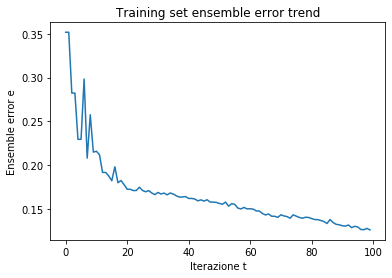

In [9]:
xs = np.arange(0, len(adaboost.errors))
plt.plot(xs, adaboost.errors)
plt.xlabel("Iterazione t")
plt.ylabel("Ensemble error e")
plt.title("Training set ensemble error trend")
plt.show()

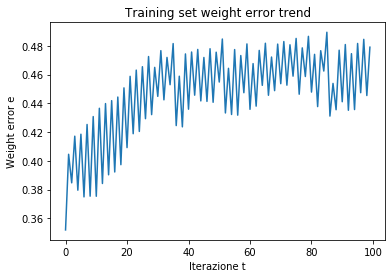

In [10]:
xs = np.arange(0, len(adaboost.weight_error))
plt.plot(xs, adaboost.weight_error)
plt.xlabel("Iterazione t")
plt.ylabel("Weight error e")
plt.title("Training set weight error trend")
plt.show()

**Note 1**:  
since the labels are bound to be in ${+1, -1}$, the classification error (i.e., the number of incorrectly classified examples over the total number of examples) can be easily computed as:
$$
   error(y,y') = \frac{N - y \cdot y'}{2N} = \frac{1}{2} - \frac{y \cdot y'}{2N},
$$
where $N$ is the total number of examples. The formula can be derived noticing that $y \cdot y'$ calculates the number $N_c$ of examples correctly classified  minus the number $N_{\bar c}$ of examples incorrectly classified. We have then $y \cdot y' = N_c - N_{\bar c}$ and by noticing that $N = N_c + N_{\bar c}$:
$$
   N - y \cdot y' = N_c + N_{\bar c} - N_c + N_{\bar c} = 2 N_{\bar c} \Rightarrow \frac{N - y \cdot y'}{2 N} = \frac{N_{\bar c}}{N}
$$

**Note 2**:
do not forget to deepcopy your base model before fitting it to the new data

**Note 3**:
The SVC model allows specifying weights, but it *does not* work well when weights are normalized (it works well when the weights are larger). The following class takes normalized weights and denormalize them before passing them to the SVC classifier:

```python
    class SVC_:
        def __init__(self, kernel="rbf", degree="3"):
            self.svc = SVC(kernel=kernel, degree=degree)

        def fit(self, X,y,sample_weight=None):
            if sample_weight is not None:
                sample_weight = sample_weight * len(X)

            self.svc.fit(X,y,sample_weight=sample_weight)
            return self

        def predict(self, X):
            return self.svc.predict(X)
```

# Exercise 2

1. Write a weak learner to be used with the AdaBoost algorithm you just wrote. The weak learner that you will implement is the most inaccurate weak learner possible: it basically works by extracting a linear model at random and trying to use that model to classify the examples. Being extracted at random the models it generates do not guarantee that the weighted error $\epsilon_t$ is smaller than $0.5$. The algorithm solves this problem by flipping the decisions whenever it finds out that $\epsilon_t > 0.5$ (i.e., if the weighted error is larger than $0.5$ it reverses the sign of all the weights so that the decision surface stays the same, but the regions where it predicts $+1$ and $-1$ are reversed).

    It shall work as follows:

    - it creates a random linear model by generating the needed weight vector $\mathbf{w}$ at random (**note**: these are the weights of the linear model, they are *NOT* related in any way to the weights of the examples); each weight shall be sampled from U(-1,1);
    - it evaluates the weighted loss $\epsilon_t$ on the given dataset and flip the linear model if $\epsilon_t > 0.5$;
    - at prediction time it predicts +1 if $\mathbf{x} \cdot \mathbf{w} > 0$; it predicts -1 otherwise.

In [11]:
class RandomLinearModel:
    # Peso totale degli elementi classificati in maniera errata
    def loss(self, y, y_, w):
        # True.astype(int) = 1
        # False.astype(int) = 0
        error = np.dot(w, ((y * y_) < 0).astype(int)) # w_i * [y_i != m_t(xi)] = 1 
        return error
        
    def fit(self, X, y, example_weights):
        self.w_ = np.random.uniform(-1, 1, X.shape[1]) # Genero il weight vector con pesi U(-1,1);
        err = self.loss(y, self.predict(X), example_weights)
        # print(err)
        # flip
        if err > 0.5:
            self.w_ * -1
        return self    
        
    def predict(self, X):
        return np.sign(np.dot(X, self.w_))

2. Learn an AdaBoost model using the RandomLinearModel weak learner printing every $K$ iterations the weighted error and the current error of the ensemble (you are free to choose $K$ so to make your output just frequent enough to let you know what is happening but without flooding the console with messages). Evaluate the training and test error of the final ensemble model.

In [12]:
rs = RandomLinearModel()
a = AdaBoost(rs, 5000, k_step=300).fit(X_train,y_train)

1 	Weight error: 0.4916 	 Ensamble error: 0.4916
301 	Weight error: 0.4999 	 Ensamble error: 0.4399
601 	Weight error: 0.5026 	 Ensamble error: 0.4119
901 	Weight error: 0.5017 	 Ensamble error: 0.3956
1201 	Weight error: 0.501 	 Ensamble error: 0.3788
1501 	Weight error: 0.4931 	 Ensamble error: 0.372
1801 	Weight error: 0.4932 	 Ensamble error: 0.361
2101 	Weight error: 0.5004 	 Ensamble error: 0.353
2401 	Weight error: 0.5019 	 Ensamble error: 0.34
2701 	Weight error: 0.4979 	 Ensamble error: 0.3306
3001 	Weight error: 0.5096 	 Ensamble error: 0.3235
3301 	Weight error: 0.495 	 Ensamble error: 0.3171
3601 	Weight error: 0.5001 	 Ensamble error: 0.3085
3901 	Weight error: 0.5011 	 Ensamble error: 0.3001
4201 	Weight error: 0.5009 	 Ensamble error: 0.291
4501 	Weight error: 0.5024 	 Ensamble error: 0.2845
4801 	Weight error: 0.5032 	 Ensamble error: 0.2734


Training Set

Accuracy 	 Error
0.728875 	 0.271125

------------------------------
Test Set

Accuracy 	 Error
0.502500 	 0.497500



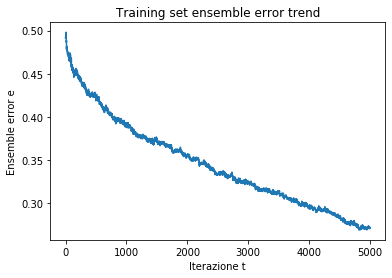

In [13]:
y_train_pred = a.predict(X_train)
y_test_pred = a.predict(X_test)

print("Training Set\n")
print("Accuracy \t Error")
print("%5f \t %5f\n" % (accuracy_score(y_train, y_train_pred), compute_error(y_train, y_train_pred)))
print("-" * 30)
print("Test Set\n")
print("Accuracy \t Error")
print("%5f \t %5f\n" % (accuracy_score(y_test, y_test_pred), compute_error(y_test, y_test_pred)))

xs = np.arange(0, len(a.errors))
plt.plot(xs, a.errors)
plt.xlabel("Iterazione t")
plt.ylabel("Ensemble error e")
plt.title("Training set ensemble error trend")
plt.show()

3. Write few paragraphs about what you think about the experiment and about the results you obtained.

Possiamo notare come, rispetto all'utilizzo del weakLearner SVC, Adaboost con il RandomLinearModel impieghi molte più iterazioni per ottenere una buona accuratezza sul training set. Questo è molto probabilmente dovuto all'utilizzo di modelli lineari inageguati che tendenzialmente commentono un errore che si aggira intorno al 50% degli esempi.

In generale Adaboost fa quindi molta fatica ad ottenere una buona accuratezza sul test set (non riesce dunque a generalizzare adeguatamente)